# Training EfficientNet
Here employ transfer learning to tune an efficientnet for AI image detection.



In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

2025-03-23 10:55:21.031048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 1024
IMG_SIZE = (380,380)

SEED = 44

## Loading from TFRecords
We load the previously saved Records

In [3]:
eff_train_ds = load_tfrecord("records/efficientnet_train.tfrecord", BATCH_SIZE, "efficientnet").repeat()
eff_val_ds = load_tfrecord("records/efficientnet_val.tfrecord", BATCH_SIZE, "efficientnet")

2025-03-23 10:55:23.945879: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 10:55:25.621993: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 10:55:25.622044: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 10:55:25.624244: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:906] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.3/numa_node
Your kernel may have been built without NUMA support.
2025-03-23 10:55:25.624354: I external/local_xla/xla/stream_executor

We see below that the images are succesfully resized and Cutmixed

(380, 380, 3)


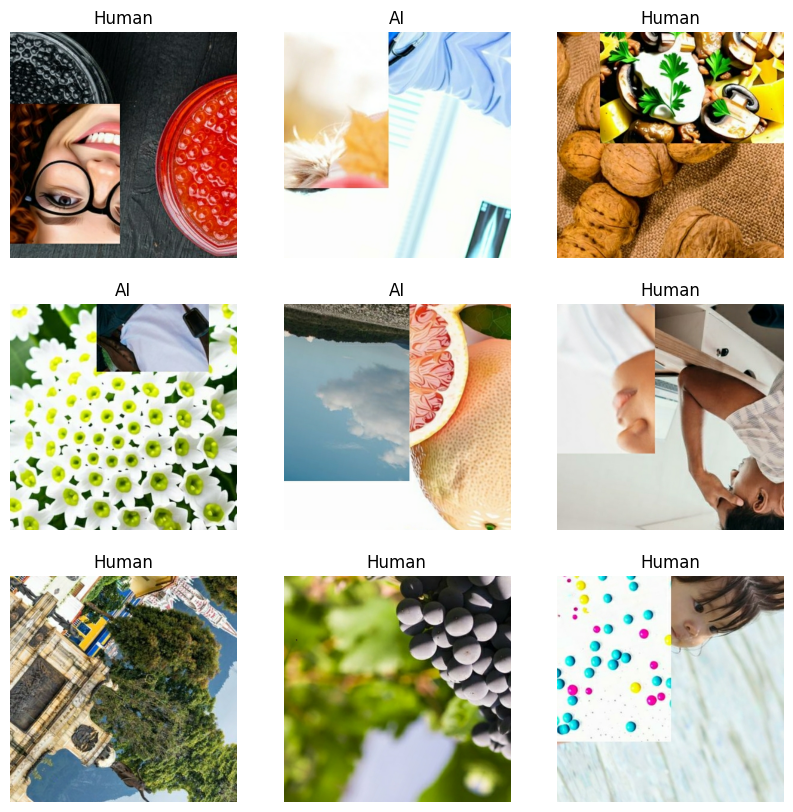

In [4]:

image_batch, label_batch = next(iter(eff_train_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")


## Initialize Base EfficientNet Model
We now initialize the model without the old classfication head and freeze all the initial weights

In [4]:
base_effnet_model = keras.applications.EfficientNetB4(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base_effnet_model.trainable = False

base_effnet_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 380, 380,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 380, 380,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 380, 380,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

## Transfer Learning for new Classfication Head
### Hyperparameter search through early stopping/Hyperband optimization

Here we utilize hyperband optimization to quickly search for good performing hyperparameters, hyperband efficiently explores the parameter space and allocates more computation to parameters that work well while dropping ones that underperform. Specifically we use hyperband for the learning rate, decay steps, dropout rate, and number of hidden units. Hyperband has also been shown to outperform Bayesian Optimization in speed by 5-30x  for deep learning problems. [1](https://arxiv.org/pdf/1603.06560)

Because of computational constraints we fix Batch Size, and Epochs and use Early Stopping on the Validation F1 Score.

Warning: the below code takes a long time to run, we will provide the selected hyperparameters from hyperband

In [5]:
EPOCHS = 32
BATCH_SIZE = 32


In [6]:
def effnet_model(hparams):
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = base_effnet_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    units = hparams.Int("num_units", min_value=64, max_value=256, step=32)
    x = keras.layers.Dense(units, activation='relu')(x)
    dropout = hparams.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
    x = keras.layers.Dropout(dropout, seed=SEED)(x)
    outputs = keras.layers.Dense(2, activation='softmax')(x)
    effnet_model = keras.Model(inputs, outputs)
    
 
    # Tune initial learning rate
    initial_learning_rate = hparams.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
    first_decay_steps = hparams.Int("first_decay_steps", min_value=10, max_value=100, step=10)
    
    # Apply Cosine Annealing with Restarts
    lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=first_decay_steps, 
        t_mul=2.0,  # Restarts period multiplier
        m_mul=0.9  # Decay factor after each restart
    )
        
    effnet_model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=[keras.metrics.AUC(multi_label=True),
                            keras.metrics.F1Score("macro")]) 

    return effnet_model


# Define the Hyperband tuner
tuner = kt.Hyperband(
    effnet_model,
    objective=kt.Objective("val_f1_score", direction="max"),  
    max_epochs=EPOCHS,
    factor=3,  
    directory="hyperband_tuning",
    project_name="efficientnet_tuning"
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=3)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/efficientnet_tuning")

# Run the hyperparameter search
tuner.search(
    eff_train_ds,
    validation_data=eff_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=1999,
    callbacks=[early_stopping, tensorboard_callback]
)




Trial 88 Complete [02h 52m 14s]
val_f1_score: 0.9171018600463867

Best val_f1_score So Far: 0.9371292591094971
Total elapsed time: 3d 00h 29m 05s

Search: Running Trial #89

Value             |Best Value So Far |Hyperparameter
64                |160               |num_units
0.3               |0.3               |dropout
0.00016972        |0.00068456        |learning_rate
50                |60                |first_decay_steps
32                |32                |tuner/epochs
0                 |11                |tuner/initial_epoch
0                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/32
1998/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.8346 - f1_score: 0.7567 - loss: 0.4986

2025-03-23 19:35:49.893881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 378s 174ms/step - auc: 0.8346 - f1_score: 0.7567 - loss: 0.4985 - val_auc: 0.9563 - val_f1_score: 0.8847 - val_loss: 0.3189
Epoch 2/32
1998/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - auc: 0.9102 - f1_score: 0.8321 - loss: 0.3821

2025-03-23 19:41:37.655829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - auc: 0.9102 - f1_score: 0.8321 - loss: 0.3821

2025-03-23 19:42:37.837611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12659579848509624319
2025-03-23 19:42:37.837673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16429022454281597700


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 326s 163ms/step - auc: 0.9102 - f1_score: 0.8321 - loss: 0.3821 - val_auc: 0.9636 - val_f1_score: 0.8960 - val_loss: 0.2795
Epoch 3/32
  75/1999 ━━━━━━━━━━━━━━━━━━━━ 4:43 147ms/step - auc: 0.9239 - f1_score: 0.8378 - loss: 0.3520

KeyboardInterrupt: 

We weren't able to finish tuning the hyperparameters with hyperband for this draft but we got to the last bracket and the best hyperparameters has remained the same for the last 3 brackets so we use those parameters to compare against resnet.

In [ ]:
EPOCHS=10

In [ ]:

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
save_model = keras.callbacks.ModelCheckpoint(f'efficientnet_model_hyp_tuned.keras', save_best_only=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs/efficientnet_tuning_best")
# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    eff_train_ds,
    validation_data=eff_val_ds,
    epochs=EPOCHS,
    steps_per_epoch=1999,
    callbacks=[early_stopping,
               save_model,
               tensorboard_callback]
)

Epoch 1/32
1998/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - auc_2: 0.8883 - f1_score: 0.8069 - loss: 0.4175

2025-03-23 19:50:31.133488: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 386s 181ms/step - auc_2: 0.8883 - f1_score: 0.8069 - loss: 0.4175 - val_auc_2: 0.9708 - val_f1_score: 0.9049 - val_loss: 0.2402
Epoch 2/32


/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - auc_2: 0.9324 - f1_score: 0.8546 - loss: 0.3314

2025-03-23 19:56:26.907651: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 333s 167ms/step - auc_2: 0.9324 - f1_score: 0.8546 - loss: 0.3314 - val_auc_2: 0.9758 - val_f1_score: 0.9133 - val_loss: 0.2175
Epoch 3/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - auc_2: 0.9423 - f1_score: 0.8678 - loss: 0.3067

2025-03-23 20:02:07.033135: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 340s 170ms/step - auc_2: 0.9423 - f1_score: 0.8678 - loss: 0.3067 - val_auc_2: 0.9805 - val_f1_score: 0.9235 - val_loss: 0.1919
Epoch 4/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc_2: 0.9552 - f1_score: 0.8838 - loss: 0.2716

2025-03-23 20:07:45.444289: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 338s 169ms/step - auc_2: 0.9552 - f1_score: 0.8838 - loss: 0.2716 - val_auc_2: 0.9796 - val_f1_score: 0.9229 - val_loss: 0.1918
Epoch 5/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc_2: 0.9534 - f1_score: 0.8807 - loss: 0.2758

2025-03-23 20:13:23.983212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 339s 169ms/step - auc_2: 0.9534 - f1_score: 0.8807 - loss: 0.2758 - val_auc_2: 0.9819 - val_f1_score: 0.9267 - val_loss: 0.1843
Epoch 6/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - auc_2: 0.9601 - f1_score: 0.8903 - loss: 0.2560

2025-03-23 20:18:59.477079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 335s 168ms/step - auc_2: 0.9601 - f1_score: 0.8903 - loss: 0.2560 - val_auc_2: 0.9836 - val_f1_score: 0.9331 - val_loss: 0.1705
Epoch 7/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - auc_2: 0.9674 - f1_score: 0.9025 - loss: 0.2328

2025-03-23 20:24:36.306305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 337s 169ms/step - auc_2: 0.9674 - f1_score: 0.9025 - loss: 0.2328 - val_auc_2: 0.9837 - val_f1_score: 0.9325 - val_loss: 0.1711
Epoch 8/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc_2: 0.9713 - f1_score: 0.9088 - loss: 0.2204

2025-03-23 20:30:15.164333: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 339s 169ms/step - auc_2: 0.9713 - f1_score: 0.9088 - loss: 0.2204 - val_auc_2: 0.9825 - val_f1_score: 0.9283 - val_loss: 0.1802
Epoch 9/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc_2: 0.9645 - f1_score: 0.8966 - loss: 0.2409

2025-03-23 20:35:54.160845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 339s 170ms/step - auc_2: 0.9645 - f1_score: 0.8966 - loss: 0.2409 - val_auc_2: 0.9840 - val_f1_score: 0.9359 - val_loss: 0.1668
Epoch 10/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc_2: 0.9684 - f1_score: 0.9022 - loss: 0.2277

2025-03-23 20:41:31.705237: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 337s 169ms/step - auc_2: 0.9684 - f1_score: 0.9022 - loss: 0.2277 - val_auc_2: 0.9846 - val_f1_score: 0.9364 - val_loss: 0.1661
Epoch 11/32


2025-03-23 20:42:33.881099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12659579848509624319
2025-03-23 20:42:33.881200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16429022454281597700


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - auc_2: 0.9728 - f1_score: 0.9110 - loss: 0.2119

2025-03-23 20:47:14.422226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 345s 173ms/step - auc_2: 0.9728 - f1_score: 0.9110 - loss: 0.2119 - val_auc_2: 0.9842 - val_f1_score: 0.9355 - val_loss: 0.1675
Epoch 12/32


2025-03-23 20:48:18.646703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12659579848509624319
2025-03-23 20:48:18.646797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16429022454281597700


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - auc_2: 0.9766 - f1_score: 0.9175 - loss: 0.1974

2025-03-23 20:53:07.396945: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 351s 176ms/step - auc_2: 0.9766 - f1_score: 0.9175 - loss: 0.1974 - val_auc_2: 0.9848 - val_f1_score: 0.9360 - val_loss: 0.1660
Epoch 13/32


2025-03-23 20:54:09.925899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12659579848509624319
2025-03-23 20:54:09.925966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16429022454281597700


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - auc_2: 0.9795 - f1_score: 0.9231 - loss: 0.1854

2025-03-23 20:58:43.189124: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13862656 bytes after encountering the first element of size 13862656 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 336s 168ms/step - auc_2: 0.9795 - f1_score: 0.9231 - loss: 0.1854 - val_auc_2: 0.9846 - val_f1_score: 0.9349 - val_loss: 0.1681


2025-03-23 20:59:45.775738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12659579848509624319
2025-03-23 20:59:45.775800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16429022454281597700


## Fine Tuning Convolutional Layer

Here we don't use Cosine Decay as we only want to very slowly fine tune the weights instead of taking big strides to small, we carefully unfreeze all convolutional layers but leave the batch normalization layers untouched

In [9]:
EPOCHS = 16
LEARNING_RATE = 1e-5

In [ ]:
base_effnet_model.trainable = True
best_model.summary(show_trainable=True)
best_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.AUC(multi_label=True),
                            keras.metrics.F1Score("macro")])

best_model.fit(eff_train_ds, 
                 epochs=EPOCHS, 
                 steps_per_epoch=1999,
                 callbacks=[
                    keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3),
                    keras.callbacks.ModelCheckpoint(f'efficientnet_model_fine_tuned.keras', save_best_only=True),
                    keras.callbacks.TensorBoard(log_dir='logs/efficientnet_fine_tuned'),
				],
                 validation_data=eff_val_ds)

Epoch 1/16
